## Case Study: The Challenger Disaster

In [ ]:
# Set up Notebook

%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

### Logistic Modelling

In [7]:
# Challenger disaster O-ring data

# Feature names taken from UCI repository
col_names = ['Number', 'Number_TD', 'Temperature', 'Pressure', 'Order']

# Read in data, delimited by whitespace, use feature names
cdata = pd.read_csv("../datasets/o-ring-erosion-only.data", delim_whitespace=True, 
                    index_col=False, names=col_names)
cdata.sample(5)

,Number,Number_TD,Temperature,Pressure,Order
20,6,0,75,200,21
1,6,1,70,50,2
8,6,1,57,200,9
18,6,0,76,200,19
15,6,0,75,200,16


In [8]:
# Descriptive statistics
cdata.describe()

,Number,Number_TD,Temperature,Pressure,Order
count,23.0,23.000000,23.000000,23.000000,23.00000
mean,6.0,0.304348,69.565217,152.173913,12.00000
std,0.0,0.558796,7.057080,68.221332,6.78233
min,6.0,0.000000,53.000000,50.000000,1.00000
25%,6.0,0.000000,67.000000,75.000000,6.50000
50%,6.0,0.000000,70.000000,200.000000,12.00000
75%,6.0,0.500000,75.000000,200.000000,17.50000
max,6.0,2.000000,81.000000,200.000000,23.00000


From this summary description we can identify several points:
1. there are 23 instances in this data set
2. there are no missing values, since each feature has the same number in the `count` row and the `min` row _always contains a valid number_.
3. the maximum value for the number of thermal distresses is two. 

---

So let's take a look a the values in `Number_TD`:

In [9]:
cdata.Number_TD.value_counts()

0    17
1     5
2     1
Name: Number_TD, dtype: int64

Only one instance has a non binary record. At this point we have three options:
1. delete the instance,
2. duplicate this instance so that two single failure instances exist in the data set, or
3. change the instance to report only a single thermal distress.

While any of these options might be valid from an algorithmic perspective, they differ from a modeling perspective:
1. The first option would remove valuable data from our set, which is already small. This would also make our model less predictive since this was an actual failure, and we likely do not want to under predict failures, which could have devastating effects.
2. duplicating this instance would be the same as having two separate launches at the same temperature. This could also be problematic, as it would overemphasize a failure at a given temperature.

As a result, we will instead convert this instance to a single thermal distress. The reason in this case is that this measurement did find an instance of a thermal distress, and we are creating a model between temperature and the probability of a thermal failure.

-----

In [10]:
# Modify instances with multiple thermal distresses
cdata.loc[cdata['Number_TD'] > 1, 'Number_TD' ] = 1

---
Now that our data are prepared, we can model this data by using a logit function. To do this we will use the statsmodels module:

In [11]:
import statsmodels.api as sm

---
Our first step is to construct our feature and label arrays. For the former, we extract the `Temperature` feature and explicitly add a constant term so that we start with a linear regression:

In [12]:
features = sm.add_constant(cdata['Temperature'], prepend=False)
label = cdata['Number_TD']

Next, we create a logit estimator, and fit this estimator to the feature and label arrays:

In [17]:
lgt_model = sm.Logit(label, features)
lgt = lgt_model.fit()

# Display the best fit intercept and slope:
print('\n', lgt.params)

Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 Temperature    -0.366701
const          23.774955
dtype: float64


---
We can now compare the newly generated logit model to the original data.

Let's convert the logit model to a set of predictive values to compare with our data. This task is accomplished by generating a set of linearly spaced independent values spanning the temperature range of interest:

In [18]:
x = np.linspace(50, 85)

Finally, we compute  the logistic function:

In [19]:
lgy = lgt.params['const'] + lgt.params['Temperature'] * x

One last thing: we must substract our model from one, since it was trained to predict failures and not successes: 1 becomes 0 and 0 becomes 1

In [20]:
# We subtract fit from one since in the data fail = 1.
# A normal logit model is fail = 0
y = 1 - 1.0 / (1.0 + np.exp(lgy))

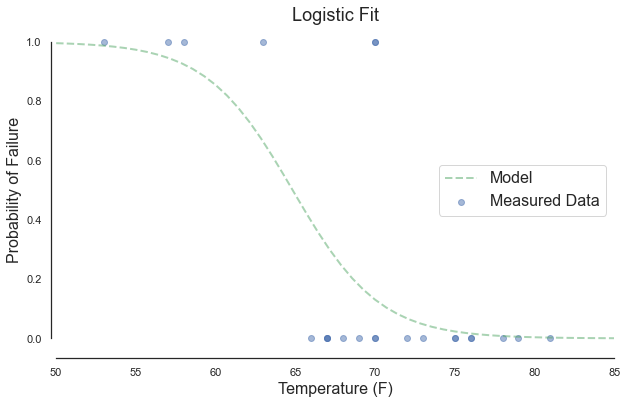

In [25]:
# Plots
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(cdata['Temperature'], cdata['Number_TD'],
            c='b', alpha = 0.5, label=f'Measured Data')
ax.plot(x, y, c='g', alpha = 0.5, lw=2, linestyle='--', label='Model')

ax.set_title('Logistic Fit', fontsize=18)
ax.set_xlabel('Temperature (F)', fontsize=16)
ax.set_ylabel('Probability of Failure', fontsize=16)
ax.set_xlim(50, 85)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc=7, fontsize=16)
sns.despine(offset=5, trim=True)

-----

Given a predictive model such as our computed logit model, we can also predict for new, unseen data. In this case, we can predict the probability of thermal failure for a given temperature. The following Code cell computes and displays these probabilities as a function of temperature. Note, that the temperature at launch during the Challenger disaster was 36 degrees Fahrenheit.

-----

In [26]:
# Compute the probability of failure for different temperatures
for t in [36, 58, 65, 72, 88]:
    str = f'P(Fail) of O-Ring at {t} deg. = {lgt.predict([t, 1])[0]:4.2f}%'
    print(str)

P(Fail) of O-Ring at 36 deg. = 1.00%
P(Fail) of O-Ring at 58 deg. = 0.92%
P(Fail) of O-Ring at 65 deg. = 0.48%
P(Fail) of O-Ring at 72 deg. = 0.07%
P(Fail) of O-Ring at 88 deg. = 0.00%


---
### Logistic Regression

We can also compute a logistic regression to these data by using the scikit-learn library. In this case we will use the `LogisticRegression` estimatror.

The estimator accepts a number of hyperparameters, of which the most important for our purposes include:
- `C`: inverse of regulariztion strength
- `class_weight`: weights to be applied to classes when performing regression, default is uniform
- `penalty`: type of regularization to be applied, can be `l1` or `l2`
- `fit_intercept`: specifies if a constant term should be included in the regression, the default is `True`
- `random_state`: the seed used to initialize the random number generator, a constant value, that ensures reproducibility!

To minimize the effects of regularization, we will introduce a high value for the C hyperparameter, which will reduce the impact of regularization on our model fit

In [ ]:
from